In [1]:
#Importing necessary libraries
import hopsworks
import hsfs
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler  # Import StandardScaler from scikit-learn
import joblib
from prophet import Prophet

load_dotenv()

#Connecting to hopsworks
api_key = os.environ.get('hopsworks_api')
project = hopsworks.login(api_key_value=api_key)
fs = project.get_feature_store()

#Another connection to hopsworks
api_key = os.getenv('hopsworks_api')
connection = hsfs.connection()
fs = connection.get_feature_store()

2024-10-13 19:47:59,047 WARNING: DeprecationWarning: Type google._upb._message.MessageMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.

2024-10-13 19:47:59,048 WARNING: DeprecationWarning: Type google._upb._message.ScalarMapContainer uses PyType_Spec with a metaclass that has custom tp_new. This is deprecated and will no longer be allowed in Python 3.14.

2024-10-13 19:48:06,146 WARNING: FutureIncompatibilityWarning: 

This is a future version incompatibility warning from Holidays library v0.58
to inform you about an upcoming change in our API versioning strategy that may affect your
project's dependencies. Starting from version 1.0 onwards, we will be following a loose form of
Semantic Versioning (SemVer, https://semver.org) to provide clearer communication regarding any
potential breaking changes.

This means that while we strive to maintain backward compatibility, there might be occasional
updates

In [3]:
#Getting the feature view
feature_view = fs.get_feature_view(
    name='amd_stocks_fv',
    version=8
)

In [5]:
df = feature_view.get_batch_data()


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.58s) 


In [6]:
df['date'] = pd.to_datetime(df['date'])


In [7]:
df = df.sort_values('date')

In [9]:
print("Columns in df:")
print(df.columns.tolist())

Columns in df:
['date', 'f_1__open', 'f_2__high', 'f_3__low', 'f_5__volume', 'ticker']


In [14]:
prophet_df = df[['date', 'f_1__open']].rename(columns={'date': 'ds', 'f_1__open': 'y'})

Data range in prophet_df: 1999-11-01 00:00:00 to 2024-10-04 00:00:00
2024-10-13 19:59:35,320 DEBUG: cmd: where.exe tbb.dll
cwd: None
2024-10-13 19:59:35,371 DEBUG: TBB already found in load path
2024-10-13 19:59:35,390 DEBUG: input tempfile: C:\Users\svjen\AppData\Local\Temp\tmpkfyiavbp\jl5ya8wd.json
2024-10-13 19:59:35,433 DEBUG: input tempfile: C:\Users\svjen\AppData\Local\Temp\tmpkfyiavbp\tstnymak.json
2024-10-13 19:59:35,435 DEBUG: idx 0
2024-10-13 19:59:35,436 DEBUG: running CmdStan, num_threads: None
2024-10-13 19:59:35,436 DEBUG: CmdStan args: ['C:\\Users\\svjen\\OneDrive\\Skrivebord\\Github_repos\\ML_ops_stocks\\.conda\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=93117', 'data', 'file=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmpkfyiavbp\\jl5ya8wd.json', 'init=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmpkfyiavbp\\tstnymak.json', 'output', 'file=C:\\Users\\svjen\\AppData\\Local\\Temp\\tmpkfyiavbp\\prophet_model_jztkx3a\\prophet_model-20241013195935.

19:59:35 - cmdstanpy - INFO - Chain [1] start processing


2024-10-13 19:59:35,437 INFO: Chain [1] start processing


19:59:35 - cmdstanpy - INFO - Chain [1] done processing


2024-10-13 19:59:35,508 INFO: Chain [1] done processing
2024-10-13 19:59:35,599 WARNING: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

Mean Absolute Error (MAE): 14.75591292804646
Root Mean Squared Error (RMSE): 17.237253378110058


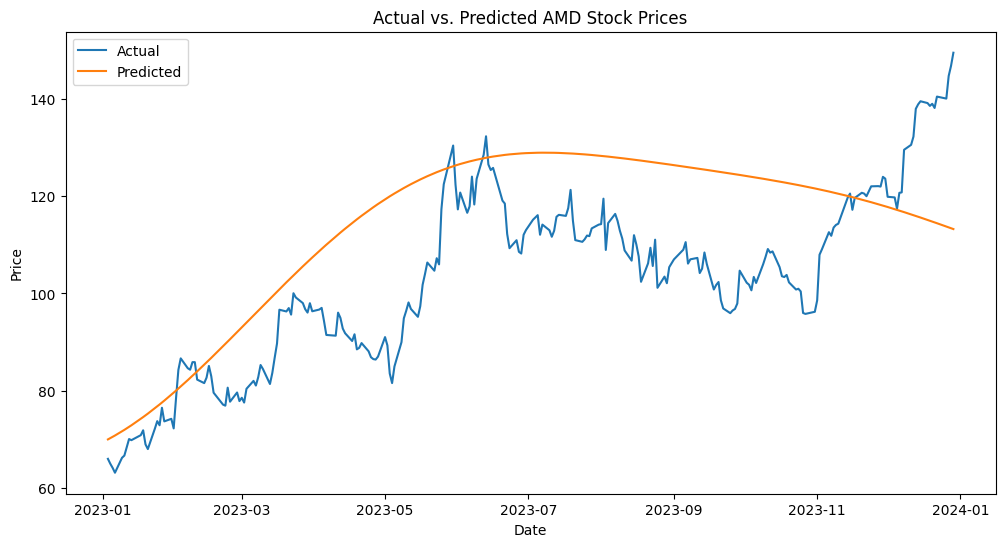

In [15]:
from datetime import datetime

# Remove timezone information from 'ds' column
prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

# Setting up train & test split dates
train_start = "2020-06-13"
train_end = "2022-12-31"

test_start = "2023-01-01"
test_end = "2023-12-31"

# Convert the date strings to datetime objects
train_start_date = datetime.strptime(train_start, "%Y-%m-%d")
train_end_date = datetime.strptime(train_end, "%Y-%m-%d")
test_start_date = datetime.strptime(test_start, "%Y-%m-%d")
test_end_date = datetime.strptime(test_end, "%Y-%m-%d")

# Verify the data range in prophet_df
print("Data range in prophet_df:", prophet_df['ds'].min(), "to", prophet_df['ds'].max())

# Split the data
train_df = prophet_df[
    (prophet_df['ds'] >= train_start_date) & (prophet_df['ds'] <= train_end_date)
]

test_df = prophet_df[
    (prophet_df['ds'] >= test_start_date) & (prophet_df['ds'] <= test_end_date)
]

# Proceed with modeling
model = Prophet(daily_seasonality=True)
model.fit(train_df)

# Use the dates from the test set for prediction
future_dates = test_df[['ds']]

# Generate forecasts
forecast = model.predict(future_dates)

# Merge the forecast with the actual test data
forecast_df = forecast[['ds', 'yhat']].set_index('ds')
actual_df = test_df.set_index('ds')

comparison_df = actual_df.join(forecast_df, how='left').dropna()

# Compute evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(comparison_df['y'], comparison_df['yhat'])
rmse = mean_squared_error(comparison_df['y'], comparison_df['yhat'], squared=False)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Visualize the results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['y'], label='Actual')
plt.plot(comparison_df.index, comparison_df['yhat'], label='Predicted')
plt.legend()
plt.title('Actual vs. Predicted AMD Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


In [9]:
# Setting up train & test split dates
train_start = "2020-06-13"
train_end = "2023-12-31"

test_start = "2024-01-13"
test_end = "2024-10-13"

In [10]:
feature_view.create_train_test_split(
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    data_format='csv',
    coalesce=True,
    statistics_config={'histogram': True, 'correlations': True}
)

Training dataset job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/564374/jobs/named/amd_stocks_fv_8_create_fv_td_13102024093206/executions
2024-10-13 11:33:36,220 WARNING: VersionWarning: Incremented version to `1`.



(1, <hsfs.core.job.Job at 0x1d3d159b7a0>)

In [11]:
#retrieving the training data from hopsworks
X_train, X_test, y_train, y_test = feature_view.get_train_test_split(1)

In [12]:
X_train

,date,f_1__open,f_2__high,f_3__low,f_5__volume,ticker
0,2023-12-12T00:00:00.000Z,132.250,139.8900,131.90,111677821.0,AMD
1,2023-11-28T00:00:00.000Z,121.980,122.5400,120.79,32047063.0,AMD
2,2021-05-24T00:00:00.000Z,77.260,78.0100,76.80,33194287.0,AMD
3,2021-11-22T00:00:00.000Z,157.140,161.8799,152.39,58674078.0,AMD
4,2023-01-30T00:00:00.000Z,74.230,74.6400,72.40,48105243.0,AMD
...,...,...,...,...,...,...
888,2020-10-06T00:00:00.000Z,86.210,87.2500,83.54,52725432.0,AMD
889,2021-04-20T00:00:00.000Z,80.820,81.1100,78.51,34977750.0,AMD
890,2021-08-12T00:00:00.000Z,107.390,108.4400,105.86,60625725.0,AMD
891,2023-12-07T00:00:00.000Z,120.785,128.6800,119.56,118579097.0,AMD


In [13]:
#Converting date into datetime
X_train['date'] = pd.to_datetime(X_train['date']).dt.date
X_test['date'] = pd.to_datetime(X_test['date']).dt.date
X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [15]:
#inspecting the format of the data
X_train.head(10)

,date,f_1__open,f_2__high,f_3__low,f_5__volume,ticker
0,2023-12-12,132.2500,139.8900,131.90,111677821.0,AMD
1,2023-11-28,121.9800,122.5400,120.79,32047063.0,AMD
2,2021-05-24,77.2600,78.0100,76.80,33194287.0,AMD
3,2021-11-22,157.1400,161.8799,152.39,58674078.0,AMD
4,2023-01-30,74.2300,74.6400,72.40,48105243.0,AMD
5,2022-01-31,107.9300,114.3100,106.90,97205994.0,AMD
6,2023-10-03,101.7963,103.2900,99.17,48116980.0,AMD
7,2020-12-24,91.8000,92.5100,91.31,16705909.0,AMD
8,2021-04-19,82.1300,83.1800,80.39,39115461.0,AMD
9,2022-06-28,85.7100,86.7300,80.43,95752533.0,AMD
